<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [ ]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [ ]:
allowed_values = {
    'experience_level': {'SE', 'MI', 'EN', 'EX'},
    'employment_type': {'FT', 'PT', 'CT', 'FL'},
    'remote_ratio': {0, 50, 100},
    'company_size': {'S', 'M', 'L'}
}

for col, allowed in allowed_values.items():
    unique_vals = set(df[col].unique())
    extra = unique_vals - allowed
    if extra:
        print(f"В столбце {col} обнаружены неожиданные значения: {extra}")
    else:
        print(f"В столбце {col} все значения соответствуют разрешённым.")

В столбце experience_level все значения соответствуют разрешённым.
В столбце employment_type все значения соответствуют разрешённым.
В столбце remote_ratio все значения соответствуют разрешённым.
В столбце company_size все значения соответствуют разрешённым.


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [ ]:
df.duplicated().sum()

1171

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

In [ ]:
cat_cols = ['experience_level', 'employment_type', 'job_title',
                      'salary_currency', 'employee_residence',
                      'company_location', 'company_size']

In [ ]:
for col in cat_cols:
    print(f"\nЗначения для {col}:")
    print(df[col].value_counts())


Значения для experience_level:
experience_level
SE    1554
MI     664
EN     270
EX      96
Name: count, dtype: int64

Значения для employment_type:
employment_type
FT    2547
PT      17
CT      10
FL      10
Name: count, dtype: int64

Значения для job_title:
job_title
Data Engineer                598
Data Scientist               538
Data Analyst                 396
Machine Learning Engineer    206
Analytics Engineer            91
                            ... 
Compliance Data Analyst        1
Deep Learning Researcher       1
Staff Data Analyst             1
Data DevOps Engineer           1
Finance Data Analyst           1
Name: count, Length: 93, dtype: int64

Значения для salary_currency:
salary_currency
USD    2107
EUR     200
GBP     144
INR      59
CAD      25
AUD       9
SGD       6
BRL       6
PLN       5
CHF       4
HUF       3
DKK       3
JPY       3
TRY       3
THB       2
ILS       1
HKD       1
CZK       1
MXN       1
CLP       1
Name: count, dtype: int64

Значения для e

In [ ]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,2584.000000,2.584000e+03,2584.000000,2584.000000
mean,2022.301084,2.103653e+05,133409.280186,50.483746
std,0.749179,8.080375e+05,67136.837329,48.163707
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,9.000000e+04,84975.000000,0.000000
50%,2022.000000,1.346300e+05,130000.000000,50.000000
75%,2023.000000,1.825625e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

У нас есть значение зарплаты в долларах, что делает колонки с зарплатой в родной валюте избыточной, если мы не хотим их исследовать отдельно

In [ ]:
df = df.drop(columns=['salary', 'salary_currency'])

In [ ]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} :\n {df[col].unique()}\n")

work_year: 4 :
 [2023 2022 2020 2021]

experience_level: 4 :
 ['SE' 'MI' 'EN' 'EX']

employment_type: 4 :
 ['FT' 'CT' 'FL' 'PT']

job_title: 93 :
 ['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'MLOps Engineer' 'AI Scientist'
 'Autonomous Vehicle Technician' 'Applied Machine 

**Ваши выводы здесь**

в признаках job_title, employee_residence и company_location много категорий

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [ ]:
cont_features = ['work_year', 'remote_ratio']
cat_features = ['experience_level', 'employment_type', 'job_title',
                'employee_residence', 'company_location', 'company_size']
y_train = train_df['salary_in_usd']
y_test = test_df['salary_in_usd']

In [ ]:
X_train_cont = train_df[cont_features]
X_test_cont = test_df[cont_features]

In [ ]:
X_train_all = train_df[cont_features + cat_features]
X_test_all = test_df[cont_features + cat_features]

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

lr_cont = LinearRegression()
lr_cont.fit(X_train_cont, y_train)
y_pred_lr_cont = lr_cont.predict(X_test_cont)

mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr_cont)

mse_lr = mean_squared_error(y_test, y_pred_lr_cont)
rmse_lr = np.sqrt(mse_lr)

print(f"LinearRegression (только числовые):")
print(f"MAPE = {mape_lr:.4f}")
print(f"RMSE = {rmse_lr:.2f}")


LinearRegression (только числовые):
MAPE = 0.8291
RMSE = 64000.53


## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

catboost_cont = CatBoostRegressor(verbose=0, random_state=42)
catboost_cont.fit(X_train_cont, y_train)

y_pred_cat_cont = catboost_cont.predict(X_test_cont)

mape_cat_cont = mean_absolute_percentage_error(y_test, y_pred_cat_cont)

mse_cat_cont = mean_squared_error(y_test, y_pred_cat_cont)
rmse_cat_cont = np.sqrt(mse_cat_cont)

print("CatBoost (только числовые):")
print(f"MAPE = {mape_cat_cont:.4f}")
print(f"RMSE = {rmse_cat_cont:.2f}")


CatBoost (только числовые):
MAPE = 0.7708
RMSE = 62433.35


## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

ohe_transformer = ColumnTransformer(
    transformers=[("ohe", OneHotEncoder(handle_unknown="ignore"), cat_features)],
    remainder='passthrough'
)

lr_ohe_pipeline = Pipeline([
    ("ohe", ohe_transformer),
    ("lr", LinearRegression())
])

lr_ohe_pipeline.fit(X_train_all, y_train)
y_pred_ohe_lr = lr_ohe_pipeline.predict(X_test_all)

mape_ohe_lr = mean_absolute_percentage_error(y_test, y_pred_ohe_lr)
mse_ohe_lr = mean_squared_error(y_test, y_pred_ohe_lr)
rmse_ohe_lr = np.sqrt(mse_ohe_lr)

print("Линейная регрессия + OHE:")
print(f"MAPE = {mape_ohe_lr:.4f}")
print(f"RMSE = {rmse_ohe_lr:.2f}")

cat_ohe_pipeline = Pipeline([
    ("ohe", ohe_transformer),
    ("cat", CatBoostRegressor(verbose=0, random_state=42))
])

cat_ohe_pipeline.fit(X_train_all, y_train)
y_pred_ohe_cat = cat_ohe_pipeline.predict(X_test_all)

mape_ohe_cat = mean_absolute_percentage_error(y_test, y_pred_ohe_cat)
mse_ohe_cat = mean_squared_error(y_test, y_pred_ohe_cat)
rmse_ohe_cat = np.sqrt(mse_ohe_cat)

print("CatBoost + OHE:")
print(f"MAPE = {mape_ohe_cat:.4f}")
print(f"RMSE = {rmse_ohe_cat:.2f}")


Линейная регрессия + OHE:
MAPE = 0.4581
RMSE = 53260.72
CatBoost + OHE:
MAPE = 0.4185
RMSE = 51866.32


In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train_label = X_train_all.copy()
X_test_label  = X_test_all.copy()

for c in cat_features:
    le = LabelEncoder()
    le.fit(pd.concat([X_train_all[c], X_test_all[c]], axis=0))
    X_train_label[c] = le.transform(X_train_all[c])
    X_test_label[c]  = le.transform(X_test_all[c])

lr_label = LinearRegression()
lr_label.fit(X_train_label, y_train)
y_pred_label_lr = lr_label.predict(X_test_label)

mape_label_lr = mean_absolute_percentage_error(y_test, y_pred_label_lr)
mse_label_lr = mean_squared_error(y_test, y_pred_label_lr)
rmse_label_lr = np.sqrt(mse_label_lr)

print("\nЛинейная регрессия + LabelEncoding:")
print(f"MAPE = {mape_label_lr:.4f}")
print(f"RMSE = {rmse_label_lr:.2f}")

cat_label = CatBoostRegressor(verbose=0, random_state=42)
cat_label.fit(X_train_label, y_train)
y_pred_label_cat = cat_label.predict(X_test_label)

mape_label_cat = mean_absolute_percentage_error(y_test, y_pred_label_cat)
mse_label_cat = mean_squared_error(y_test, y_pred_label_cat)
rmse_label_cat = np.sqrt(mse_label_cat)

print("CatBoost + LabelEncoding:")
print(f"MAPE = {mape_label_cat:.4f}")
print(f"RMSE = {rmse_label_cat:.2f}")



Линейная регрессия + LabelEncoding:
MAPE = 0.6148
RMSE = 56763.40
CatBoost + LabelEncoding:
MAPE = 0.4933
RMSE = 53418.43


In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders.target_encoder import TargetEncoder

X_train_target = X_train_all.copy()
X_test_target  = X_test_all.copy()

tenc = TargetEncoder(cols=cat_features)
X_train_target = tenc.fit_transform(X_train_target, y_train)
X_test_target  = tenc.transform(X_test_target)

lr_target = LinearRegression()
lr_target.fit(X_train_target, y_train)
y_pred_target_lr = lr_target.predict(X_test_target)

mape_target_lr = mean_absolute_percentage_error(y_test, y_pred_target_lr)
mse_target_lr = mean_squared_error(y_test, y_pred_target_lr)
rmse_target_lr = np.sqrt(mse_target_lr)

print("\nЛинейная регрессия + MeanTargetEnc:")
print(f"MAPE = {mape_target_lr:.4f}")
print(f"RMSE = {rmse_target_lr:.2f}")

cat_target = CatBoostRegressor(verbose=0, random_state=42)
cat_target.fit(X_train_target, y_train)
y_pred_target_cat = cat_target.predict(X_test_target)

mape_target_cat = mean_absolute_percentage_error(y_test, y_pred_target_cat)
mse_target_cat = mean_squared_error(y_test, y_pred_target_cat)
rmse_target_cat = np.sqrt(mse_target_cat)

print("CatBoost + MeanTargetEnc:")
print(f"MAPE = {mape_target_cat:.4f}")
print(f"RMSE = {rmse_target_cat:.2f}")



Линейная регрессия + MeanTargetEnc:
MAPE = 0.4675
RMSE = 52528.79
CatBoost + MeanTargetEnc:
MAPE = 0.4813
RMSE = 52908.32


## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
import numpy as np
import pandas as pd

best_model = cat_target
X_test_enc = X_test_target 

test_df = test_df.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_pred = best_model.predict(X_test_enc)

errors = np.abs(y_test - y_pred)

top20_idx = np.argsort(errors)[-20:]

test_most_errors = test_df.iloc[top20_idx].copy()

test_most_errors["prediction"] = y_pred[top20_idx]
test_most_errors["abs_error"] = errors[top20_idx]

test_most_errors = test_most_errors.sort_values("abs_error", ascending=False)

display(test_most_errors)


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,prediction,abs_error
147,2022,MI,FT,Data Analyst,430967,GB,0,GB,M,65984.416400,364982.583600
466,2023,SE,FT,Data Analyst,385000,US,0,US,M,131198.534906,253801.465094
376,2021,MI,FT,Applied Machine Learning Scientist,38400,VN,100,US,M,216426.284085,178026.284085
479,2023,SE,FT,Applied Scientist,72000,US,0,US,L,235017.314680,163017.314680
369,2022,MI,FT,AI Scientist,200000,IN,100,US,L,43977.741393,156022.258607
24,2022,SE,FT,Data Engineer,315000,US,100,US,M,160608.710649,154391.289351
179,2020,SE,FT,Data Scientist,120000,US,50,US,L,260753.427155,140753.427155
23,2022,SE,FT,3D Computer Vision Researcher,10000,CA,50,AL,S,148742.040540,138742.040540
88,2022,MI,FT,Data Engineer,260000,US,0,US,M,129088.630758,130911.369242
264,2023,SE,FT,Data Analyst,250000,US,100,US,M,121700.361029,128299.638971


**модель может значительно недооценить, или наоборот, переоценить зарплату**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

есть идея добавить среднюю зарплату по стране и по должности

In [ ]:
avg_salary_by_country = train_df.groupby("employee_residence")["salary_in_usd"].mean()
train_df["country_avg_salary"] = train_df["employee_residence"].map(avg_salary_by_country)
test_df["country_avg_salary"] = test_df["employee_residence"].map(avg_salary_by_country)

avg_salary_by_job = train_df.groupby("job_title")["salary_in_usd"].mean()
train_df["job_avg_salary"] = train_df["job_title"].map(avg_salary_by_job)
test_df["job_avg_salary"] = test_df["job_title"].map(avg_salary_by_job)

new_cat_features = cat_features 

tenc = TargetEncoder(cols=new_cat_features)

X_train_new = train_df[cont_features + new_cat_features + ["country_avg_salary", "job_avg_salary"]]
X_test_new = test_df[cont_features + new_cat_features + ["country_avg_salary", "job_avg_salary"]]

X_train_new = tenc.fit_transform(X_train_new, y_train)
X_test_new = tenc.transform(X_test_new)

improved_model = CatBoostRegressor(verbose=0, random_state=42)
improved_model.fit(X_train_new, y_train)

y_pred_new = improved_model.predict(X_test_new)

mape_new = mean_absolute_percentage_error(y_test, y_pred_new)
mse_new = mean_squared_error(y_test, y_pred_new)
rmse_new = np.sqrt(mse_new)

print(f"MAPE = {mape_new:.4f}")
print(f"RMSE = {rmse_new:.2f}")

MAPE = 0.4046
RMSE = 51088.61


**как итог, модель удалось чуть-чуть улучшить**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [ ]:
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
X_train_final = X_train_new.copy()
X_test_final = X_test_new.copy()

param_grid = {
    "depth": [6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [500, 1000],
}

catboost = CatBoostRegressor(verbose=0, random_state=42)

grid_search = GridSearchCV(catboost, param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_search.fit(X_train_final, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры для CatBoost: ", best_params)

start_time = time.time()

final_model = CatBoostRegressor(**best_params, verbose=0, random_state=42)
final_model.fit(X_train_final, y_train)

train_time = time.time() - start_time

y_pred_final = final_model.predict(X_test_final)

mape_final = mean_absolute_percentage_error(y_test, y_pred_final)
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)

start_time = time.time()
_ = final_model.predict(X_test_final)
prediction_time = time.time() - start_time

print(f"MAPE = {mape_final:.4f}")
print(f"RMSE = {rmse_final:.2f}")
print(f"Время обучения: {train_time:.2f} сек")
print(f"Время предсказания: {prediction_time:.4f} сек")

Лучшие параметры для CatBoost:  {'depth': 6, 'iterations': 1000, 'learning_rate': 0.01}
MAPE = 0.4173
RMSE = 50453.31
Время обучения: 0.99 сек
Время предсказания: 0.0026 сек


код исполнялся две минуты

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
from xgboost import XGBRegressor

In [ ]:
X_train_final = X_train_new.copy()
X_test_final = X_test_new.copy()

param_grid = {
    "max_depth": [6, 8, 10], 
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [500, 1000],
}

xgb = XGBRegressor(random_state=42, objective="reg:squarederror", verbosity=0)

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_search.fit(X_train_final, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры для XGBoost:", best_params)

start_time = time.time()

final_xgb = XGBRegressor(**best_params, random_state=42, objective="reg:squarederror", verbosity=0)
final_xgb.fit(X_train_final, y_train)

train_time = time.time() - start_time

y_pred_xgb = final_xgb.predict(X_test_final)

mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

start_time = time.time()
_ = final_xgb.predict(X_test_final)
prediction_time = time.time() - start_time

print(f"MAPE = {mape_xgb:.4f}")
print(f"RMSE = {rmse_xgb:.2f}")
print(f"Время обучения: {train_time:.2f} сек")
print(f"Время предсказания: {prediction_time:.4f} сек")

Лучшие параметры для XGBoost: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
MAPE = 0.4634
RMSE = 54491.37
Время обучения: 0.42 сек
Время предсказания: 0.0106 сек


код исполнялся 52 сек

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
import lightgbm as lgb

In [ ]:
X_train_final = X_train_new.copy()
X_test_final = X_test_new.copy()

param_grid = {
    "max_depth": [6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1], 
    "n_estimators": [500, 1000],
    "num_leaves": [31, 50, 100]
}

lgbm = lgb.LGBMRegressor(random_state=42)

grid_search = GridSearchCV(lgbm, param_grid, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_search.fit(X_train_final, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры для LightGBM:", best_params)

start_time = time.time()

final_lgbm = lgb.LGBMRegressor(**best_params, random_state=42)
final_lgbm.fit(X_train_final, y_train)

train_time = time.time() - start_time

y_pred_lgbm = final_lgbm.predict(X_test_final)

mape_lgbm = mean_absolute_percentage_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)

start_time = time.time()
_ = final_lgbm.predict(X_test_final)
prediction_time = time.time() - start_time

print(f"MAPE = {mape_lgbm:.4f}")
print(f"RMSE = {rmse_lgbm:.2f}")
print(f"Время обучения: {train_time:.2f} сек")
print(f"Время предсказания: {prediction_time:.4f} сек")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 2067, number of used features: 10
[LightGBM] [Info] Start training from score 133570.320271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

код исполнялся полторы минуты

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

кэтбуст оказался самым точным из представленных моделей и самым быстрым в предсказании


лайтГБМ оказалась самой быстрой в обучении


ХГБуст уступает коллегам по машинным показателям, но ячеечка крутилась быстрее всех :)

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42


### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
X_train = pd.read_csv("samsung_train.txt", delim_whitespace=True, header=None)
X_test = pd.read_csv("samsung_test.txt", delim_whitespace=True, header=None)
y_train = pd.read_csv("samsung_train_labels.txt", delim_whitespace=True, header=None)
y_test = pd.read_csv("samsung_test_labels.txt", delim_whitespace=True, header=None)

<ipython-input-49-dd39b0d3fec4>:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv("samsung_train.txt", delim_whitespace=True, header=None)
<ipython-input-49-dd39b0d3fec4>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv("samsung_test.txt", delim_whitespace=True, header=None)
<ipython-input-49-dd39b0d3fec4>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv("samsung_train_labels.txt", delim_whitespace=True, header=None)
<ipython-input-49-dd39b0d3fec4>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_test = pd.read_csv("samsung_test_labels.

In [ ]:
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

в X_scaled оказались NaN, обрабатываем

In [ ]:
np.isnan(X_scaled).sum()

530

In [ ]:
rows_with_nan = np.where(np.isnan(X_scaled))[0]

In [ ]:
rows_with_nan

array([1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401,
       1401, 1401, 1401, 1401, 1401, 1401, 1401, 14

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_scaled = imputer.fit_transform(X_scaled)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.90) + 1 

print(f"Достаточно {n_components} компонент для объяснения 90% дисперсии")

pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Новая размерность данных: {X_pca.shape}")

Достаточно 62 компонент для объяснения 90% дисперсии
Новая размерность данных: (2804, 62)


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
y = y[:X_pca.shape[0]]

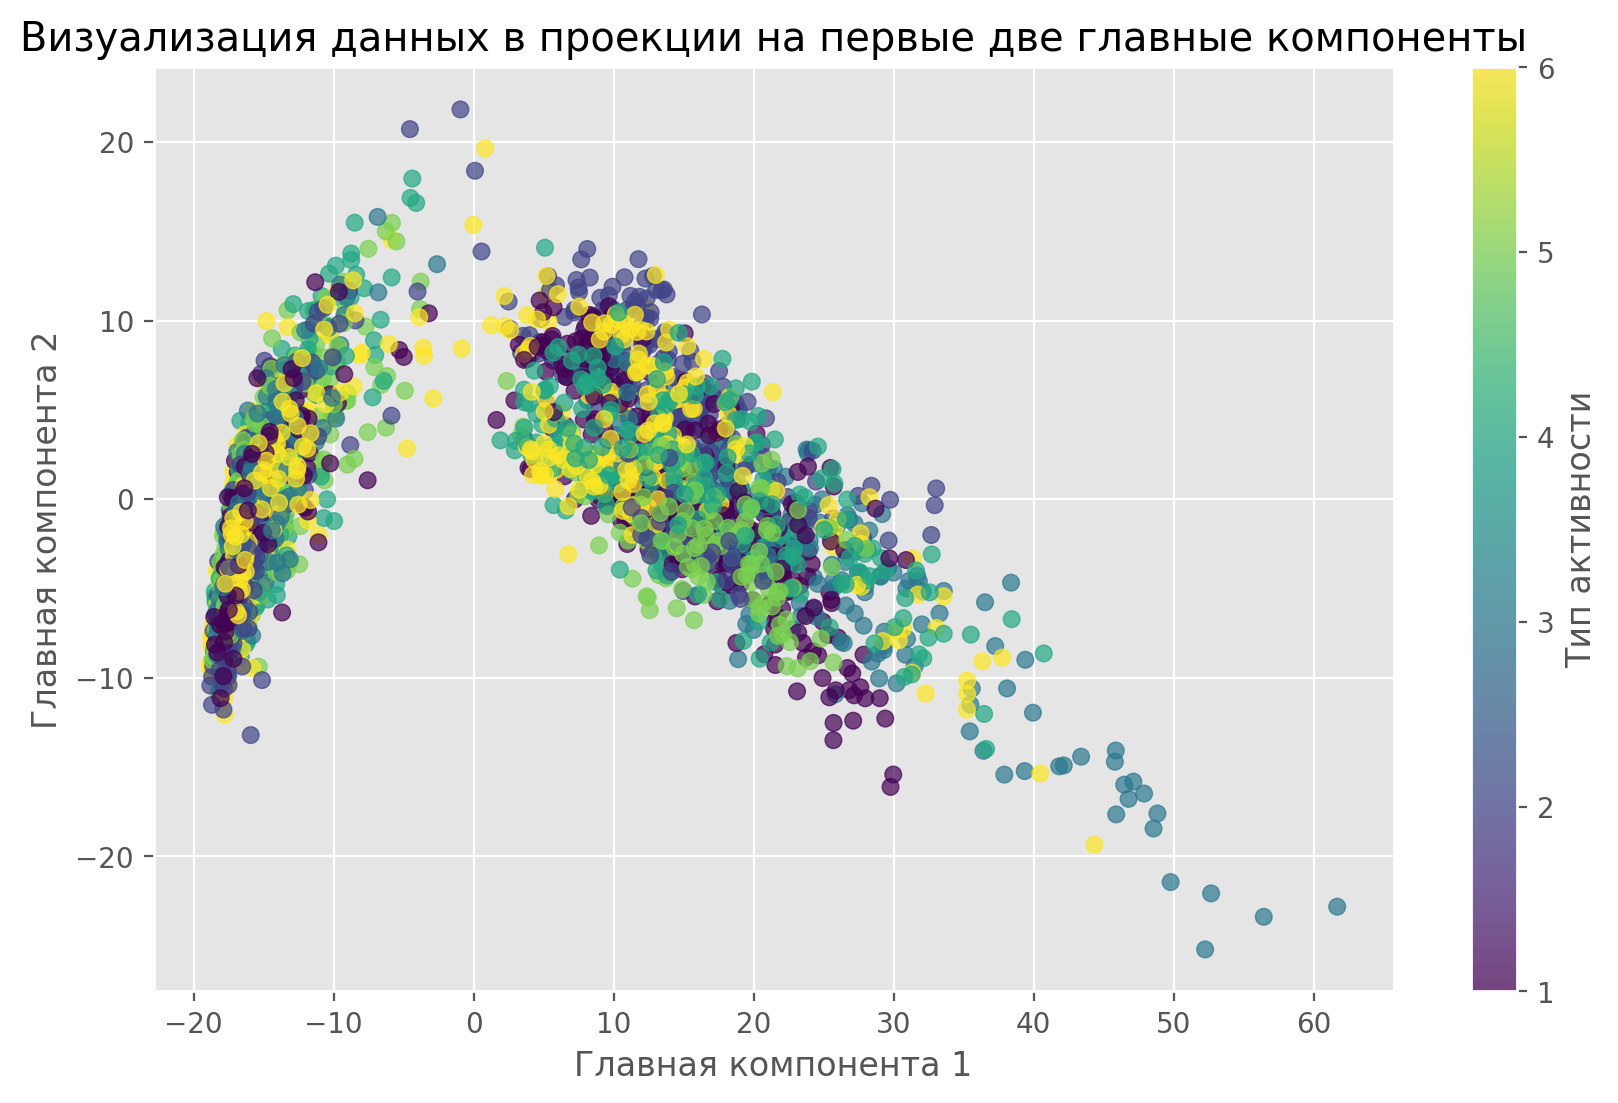

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Тип активности")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.title("Визуализация данных в проекции на первые две главные компоненты")
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
start_train = time.time()
kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
end_train = time.time()

start_pred = time.time()
clusters_kmeans = kmeans.predict(X_pca)
end_pred = time.time()

train_time = end_train - start_train
pred_time = end_pred - start_pred

print(f"Время обучения KMeans: {train_time:.4f} сек")
print(f"Время предсказания KMeans: {pred_time:.4f} сек")

print("Первые 10 предсказанных кластеров:", clusters_kmeans[:10])

Время обучения KMeans: 5.1613 сек
Время предсказания KMeans: 0.0018 сек
Первые 10 предсказанных кластеров: [0 0 0 0 0 0 0 0 0 0]


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

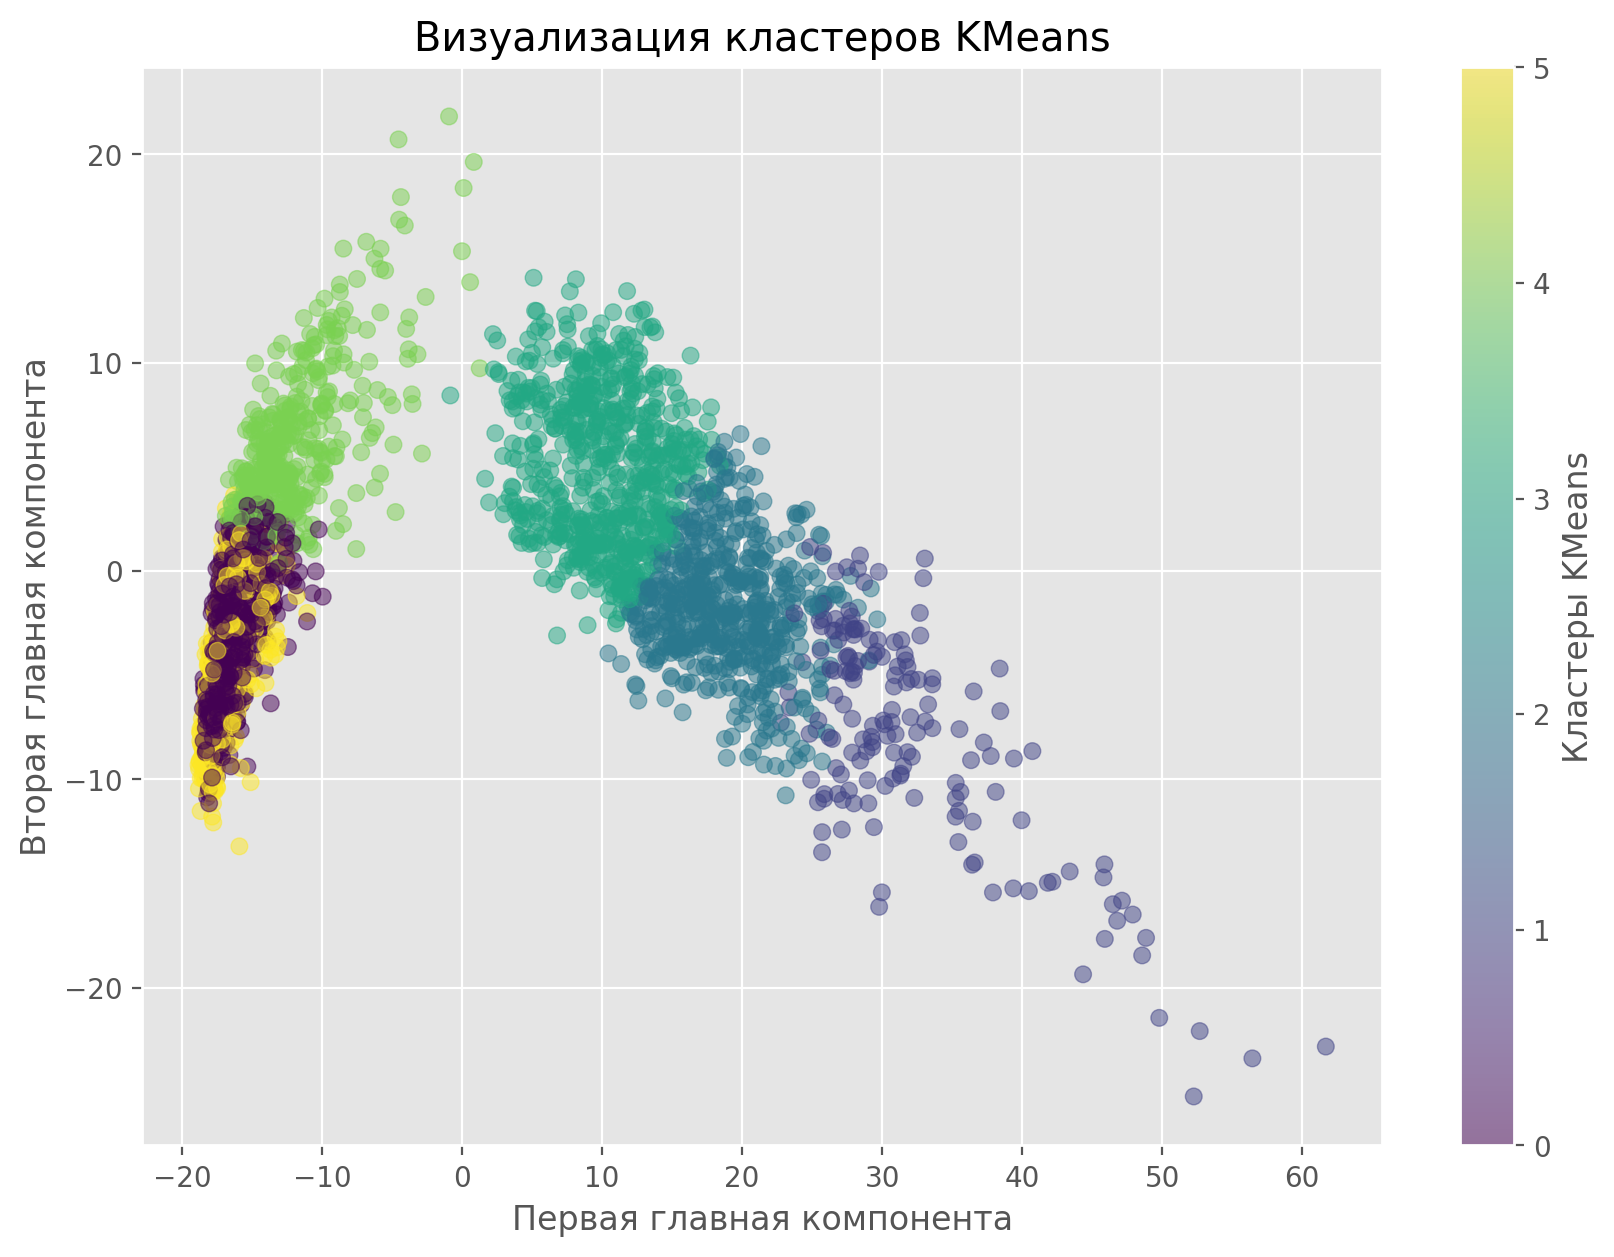

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap="viridis", alpha=0.5)
plt.colorbar(label="Кластеры KMeans")
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Визуализация кластеров KMeans")
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

silhouette = silhouette_score(X_pca, clusters_kmeans)
calinski_harabasz = calinski_harabasz_score(X_pca, clusters_kmeans)

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f}")

Silhouette Score: 0.1166
Calinski-Harabasz Score: 889.77


**оценки показывают что наши кластеры не хорошо разделены**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
from sklearn.cluster import AgglomerativeClustering
start_train = time.time()
agg_clustering = AgglomerativeClustering(n_clusters=6)
y_pred_agg = agg_clustering.fit_predict(X_pca)
end_train = time.time()

silhouette_agg = silhouette_score(X_pca, y_pred_agg)
calinski_agg = calinski_harabasz_score(X_pca, y_pred_agg)

print(f"Время обучения Agglomerative Clustering: {end_train - start_train:.4f} сек")
print(f"Silhouette Score: {silhouette_agg:.4f}")
print(f"Calinski-Harabasz Score: {calinski_agg:.2f}")

Время обучения Agglomerative Clustering: 0.8800 сек
Silhouette Score: 0.1262
Calinski-Harabasz Score: 836.00


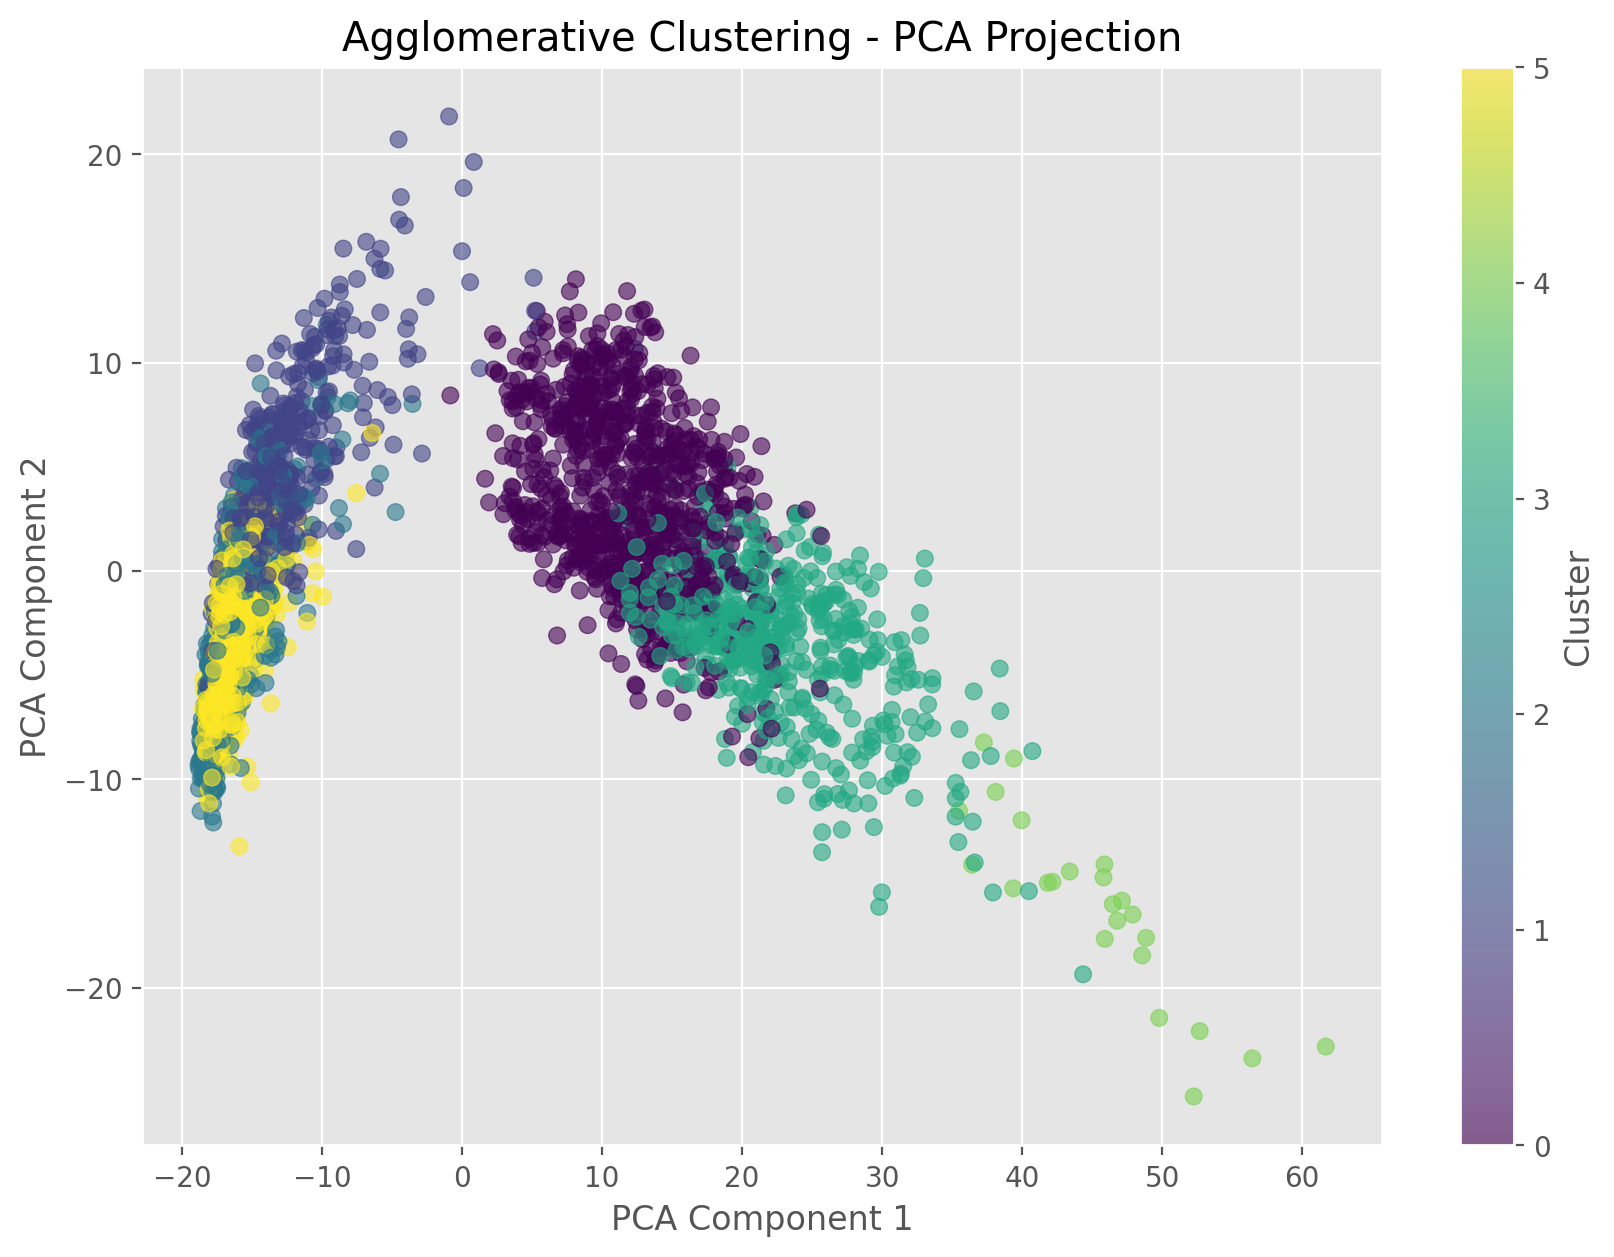

In [ ]:
agglo = AgglomerativeClustering(n_clusters=6)
agglo_labels = agglo.fit_predict(X_pca)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap="viridis", alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Agglomerative Clustering - PCA Projection")
plt.colorbar(label="Cluster")
plt.show()

**лучше стало, но незначительно. причину затрудняюсь назвать. по ощущениям стоит изменить количество кластеров.**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

In [ ]:
if isinstance(y, pd.DataFrame):
    y = y.values.ravel() 
else:
    y = np.array(y).ravel() 

agglo_labels = np.array(agglo_labels).ravel()

df_clusters = pd.DataFrame({"Cluster": agglo_labels, "True Label": y})

cluster_counts = df_clusters.groupby(["Cluster", "True Label"]).size().unstack()

display(cluster_counts)


True Label,1,2,3,4,5,6
Cluster,,,,,,
0,241.0,181.0,57.0,142.0,54.0,156.0
1,54.0,42.0,63.0,81.0,116.0,58.0
2,NaN,67.0,23.0,30.0,76.0,230.0
3,143.0,57.0,125.0,63.0,74.0,29.0
4,NaN,NaN,24.0,NaN,NaN,NaN
5,83.0,87.0,98.0,142.0,174.0,34.0


**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

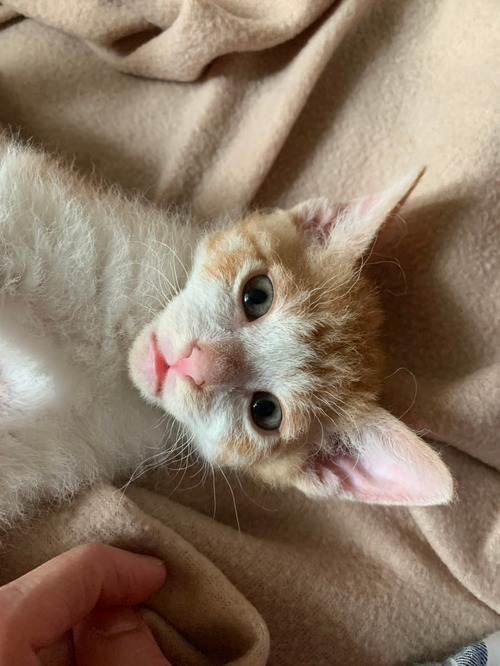

я думаю это кот @aketa147